In [194]:
import pandas as pd
import re 
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import os
from textblob import TextBlob
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [195]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 90%; }
</style>
"""))
pd.set_option('display.max_columns', 100)

In [196]:
df_train_timeseries =pd.read_csv('../Data/Bitcoin_Data2/train_timeseries2.csv',encoding='latin1')

In [197]:
df_train_timeseries.rename(columns = {"date":"Date"}, inplace=True)

In [198]:
df_train_timeseries['Date'] = df_train_timeseries.Date.apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%#m/%#d/%Y"))

In [199]:
df_train_timeseries.head(5)

,Date,close,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,n_transactions_excl_chains_longer_than_100,n_transactions_excl_popular,n_transactions_per_block,n_transactions,n_unique_addresses,output_volume,total_bitcoins,trade_volume,transaction_fees_USD,transaction_fees,mempool_count_mean,mempool_count_stddev,mempool_count_min,mempool_count_max,mempool_growth_mean,mempool_growth_stddev,mempool_growth_min,mempool_growth_max,mempool_size_mean,mempool_size_stddev,mempool_size_min,mempool_size_max,wallets_created,transactions_per_sec_mean,transactions_per_sec_stddev,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral
0,4/24/2016,458.55,0.728040,66022.67805,1.385967,8.360698,1.786780e+11,110486293.2,240501.2912,1172443.384,8.783333,1531303.620,115683,213799,1387.537879,183155,376201,2223869.595,15469775.0,29353633.46,15283.61990,33.268655,2202.066667,1588.794333,88.0,7506.0,1069.636786,428.118104,5.583333,3213.350000,2219899.211,996100.984,438969.0,5165259.0,6942443,2.151032,0.520373,0.766667,4.266667,36783070.63,27228.75866,36724621,36825214,6,2,0,4
1,4/25/2016,461.43,0.874485,66133.73765,0.888460,6.861613,1.786780e+11,168025613.1,362233.4608,1128032.650,9.683333,1492839.928,130742,246337,1713.102362,217564,407004,2719385.889,15472950.0,36817995.51,20084.42841,43.298470,2480.348611,1464.387281,78.0,6794.0,1191.776065,481.434657,410.183333,5138.366667,4165498.640,1577876.857,635561.0,8371544.0,6955905,2.477870,0.671409,0.700000,8.016667,36870963.17,17998.12914,36825828,36893715,25,7,8,10
2,4/26/2016,466.09,0.813180,66256.52779,1.129962,7.675906,1.786780e+11,170332016.5,363972.8546,1341204.175,7.750000,1924687.353,144537,235851,1660.556291,250744,436154,2770136.734,15476725.0,34854624.60,158063.23920,337.756398,2618.503472,1775.652641,401.0,8624.0,1250.323345,517.583935,43.416667,4130.333333,4377631.986,1617806.930,1807557.0,9632225.0,6968497,2.756562,0.904975,0.083333,9.500000,36931936.13,16768.83707,36895435,36980350,32,14,14,4
3,4/27/2016,444.69,0.875343,66369.44708,0.873767,6.111057,1.786780e+11,167458968.2,374368.9346,1145796.944,10.366667,1463200.885,137027,243750,1856.085271,239435,392821,2485051.224,15479950.0,42654741.36,20626.13494,46.111500,3510.391667,1759.735758,439.0,9005.0,1226.353958,581.077225,128.083333,5341.916667,5827577.172,1919135.850,2821061.0,11592705.0,6982399,2.700880,0.977362,0.433333,13.300000,37022472.54,16423.15703,36983148,37044068,18,8,4,6
4,4/28/2016,449.01,0.898219,66491.60486,0.904082,6.261128,1.786660e+11,171720826.0,381601.8356,1207843.183,10.000000,1552496.677,139845,257795,1836.725926,247958,374956,2696032.682,15483325.0,38051508.65,22329.15526,49.620345,4062.283333,2655.128851,556.0,13108.0,1284.658819,768.516052,168.600000,8741.483333,6469173.658,2009515.051,3268831.0,12091996.0,6997552,2.785637,0.803247,0.600000,11.250000,37077491.25,18568.44670,37046272,37106607,24,12,7,5


### Creating Polarity of tweets

In [200]:
df_train_tweets =pd.read_csv('../Data/Bitcoin_Data2/train_tweets.csv',encoding='latin1')

In [201]:
df_train_tweets.head()

,tweet_id,created_date,text,retweet_count,favorite_count,follower_count,account
0,7.24098E+17,4/24/2016 4:48,RT @JohnRLottJr: Hugo Chavez's 35 yr old daugh...,111.0,0,36499.0,@BitcoinMoney
1,7.24099E+17,4/24/2016 4:52,RT @zerohedge: US Taxpayer Is Now A Major Coun...,91.0,0,36499.0,@BitcoinMoney
2,7.241E+17,4/24/2016 4:57,RT @TuurDemeester: Ethereum founder has sold 2...,54.0,0,36499.0,@BitcoinMoney
3,7.24108E+17,4/24/2016 5:30,This site has the best #Bitcoin Casino games h...,0.0,1,18633.0,@cryptonewsday
4,7.24169E+17,4/24/2016 9:30,Get #Bitcoin loans: https://t.co/fyyZyHGpRr,0.0,0,18633.0,@cryptonewsday


In [202]:
def clean_tweet(tweet): 
        ''' 
        removing links, special characters  '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [203]:
def polarity(x):
     
    x = TextBlob(x)
    if x.sentiment.polarity > 0:
       return 'positive'
    elif x.sentiment.polarity == 0:
       return 'neutral'
    else:
       return 'negative'

In [204]:
df_train_tweets.dtypes

tweet_id           object
created_date       object
text               object
retweet_count     float64
favorite_count     object
follower_count    float64
account            object
dtype: object

In [205]:
df_train_tweets['text'] = df_train_tweets['text'].astype(str)

In [206]:
df_train_tweets['text'] = df_train_tweets.text.apply(lambda x:clean_tweet(x))

In [207]:
df_train_tweets['Polarity'] = df_train_tweets.text.apply(lambda x:polarity(x))

In [208]:
df_train_tweets.head()

,tweet_id,created_date,text,retweet_count,favorite_count,follower_count,account,Polarity
0,7.24098E+17,4/24/2016 4:48,RT Hugo Chavez s 35 yr old daughter has 4 2b i...,111.0,0,36499.0,@BitcoinMoney,negative
1,7.24099E+17,4/24/2016 4:52,RT US Taxpayer Is Now A Major Counterparty To ...,91.0,0,36499.0,@BitcoinMoney,positive
2,7.241E+17,4/24/2016 4:57,RT Ethereum founder has sold 25 of his ETH pos...,54.0,0,36499.0,@BitcoinMoney,positive
3,7.24108E+17,4/24/2016 5:30,This site has the best Bitcoin Casino games,0.0,1,18633.0,@cryptonewsday,positive
4,7.24169E+17,4/24/2016 9:30,Get Bitcoin loans,0.0,0,18633.0,@cryptonewsday,neutral


In [209]:
df_train_tweets[['Date','Time']] = df_train_tweets['created_date'].str.split(' ',expand=True)

In [210]:
df_train_tweets.head()

,tweet_id,created_date,text,retweet_count,favorite_count,follower_count,account,Polarity,Date,Time
0,7.24098E+17,4/24/2016 4:48,RT Hugo Chavez s 35 yr old daughter has 4 2b i...,111.0,0,36499.0,@BitcoinMoney,negative,4/24/2016,4:48
1,7.24099E+17,4/24/2016 4:52,RT US Taxpayer Is Now A Major Counterparty To ...,91.0,0,36499.0,@BitcoinMoney,positive,4/24/2016,4:52
2,7.241E+17,4/24/2016 4:57,RT Ethereum founder has sold 25 of his ETH pos...,54.0,0,36499.0,@BitcoinMoney,positive,4/24/2016,4:57
3,7.24108E+17,4/24/2016 5:30,This site has the best Bitcoin Casino games,0.0,1,18633.0,@cryptonewsday,positive,4/24/2016,5:30
4,7.24169E+17,4/24/2016 9:30,Get Bitcoin loans,0.0,0,18633.0,@cryptonewsday,neutral,4/24/2016,9:30


In [211]:
df_train_tweets.drop(['created_date','Time'],axis=1, inplace=True)

In [212]:
df_train_tweets.head()

,tweet_id,text,retweet_count,favorite_count,follower_count,account,Polarity,Date
0,7.24098E+17,RT Hugo Chavez s 35 yr old daughter has 4 2b i...,111.0,0,36499.0,@BitcoinMoney,negative,4/24/2016
1,7.24099E+17,RT US Taxpayer Is Now A Major Counterparty To ...,91.0,0,36499.0,@BitcoinMoney,positive,4/24/2016
2,7.241E+17,RT Ethereum founder has sold 25 of his ETH pos...,54.0,0,36499.0,@BitcoinMoney,positive,4/24/2016
3,7.24108E+17,This site has the best Bitcoin Casino games,0.0,1,18633.0,@cryptonewsday,positive,4/24/2016
4,7.24169E+17,Get Bitcoin loans,0.0,0,18633.0,@cryptonewsday,neutral,4/24/2016


## Caculating weighted tweet polarity

In [274]:
tweet_polarity_ext = df_train_tweets[['Date','Polarity','retweet_count','favorite_count','follower_count']]

In [275]:
dummy_2 = pd.get_dummies(tweet_polarity_ext['Polarity'])

In [276]:
tweet_polarity_ext = pd.concat([tweet_polarity_ext,dummy_2], axis=1)

In [277]:
tweet_polarity_ext.head()

,Date,Polarity,retweet_count,favorite_count,follower_count,negative,neutral,positive
0,4/24/2016,negative,111.0,0,36499.0,1,0,0
1,4/24/2016,positive,91.0,0,36499.0,0,0,1
2,4/24/2016,positive,54.0,0,36499.0,0,0,1
3,4/24/2016,positive,0.0,1,18633.0,0,0,1
4,4/24/2016,neutral,0.0,0,18633.0,0,1,0


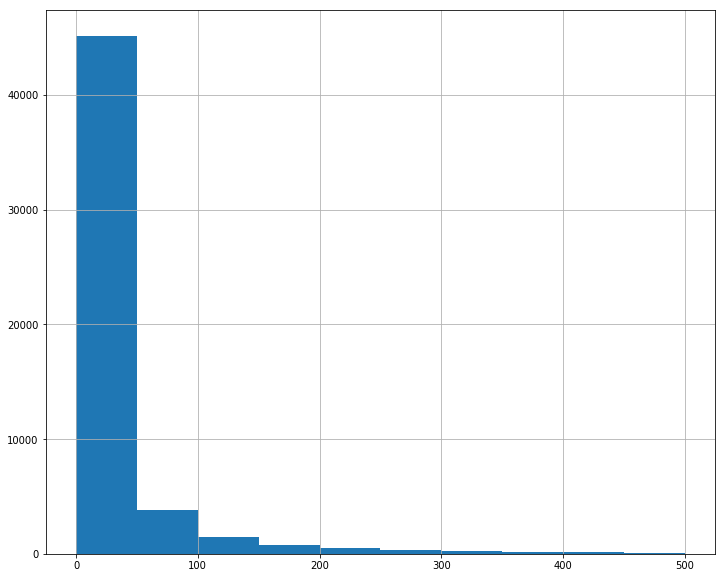

In [89]:
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
tweet_polarity_ext['retweet_count'].hist(ax = ax, range=[0,500])

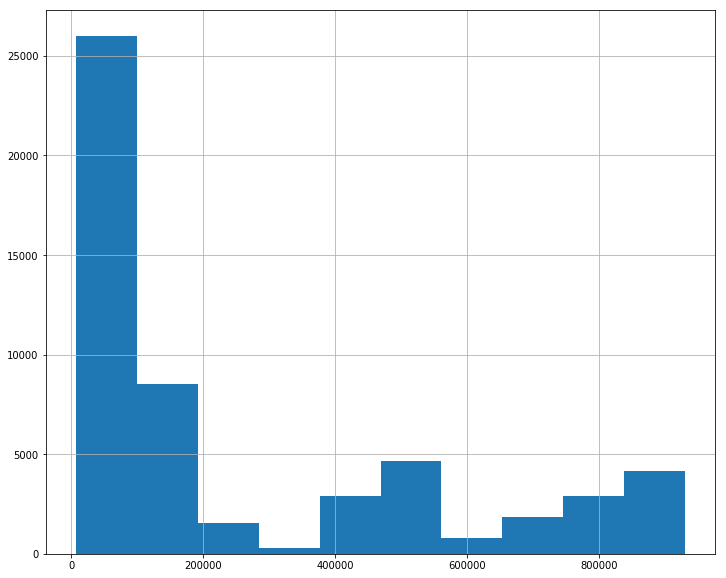

In [90]:
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
tweet_polarity_ext['follower_count'].hist(ax = ax)

In [278]:
tweet_polarity_ext = tweet_polarity_ext[tweet_polarity_ext.favorite_count != '@BitcoinByte']

In [279]:
tweet_polarity_ext.fillna(0, inplace=True)

In [219]:
tweet_polarity_ext.head()

,Date,Polarity,retweet_count,favorite_count,follower_count,negative,neutral,positive
0,4/24/2016,negative,111.0,0,36499.0,1,0,0
1,4/24/2016,positive,91.0,0,36499.0,0,0,1
2,4/24/2016,positive,54.0,0,36499.0,0,0,1
3,4/24/2016,positive,0.0,1,18633.0,0,0,1
4,4/24/2016,neutral,0.0,0,18633.0,0,1,0


In [280]:
tweet_polarity_ext['favorite_count'] = tweet_polarity_ext['favorite_count'].astype(int)

In [281]:
tweet_polarity_ext['negative'] = tweet_polarity_ext['negative'].astype(int)
tweet_polarity_ext['neutral'] = tweet_polarity_ext['neutral'].astype(int)
tweet_polarity_ext['positive'] = tweet_polarity_ext['positive'].astype(int)

In [222]:
tweet_polarity_ext.head()

,Date,Polarity,retweet_count,favorite_count,follower_count,negative,neutral,positive
0,4/24/2016,negative,111.0,0,36499.0,1,0,0
1,4/24/2016,positive,91.0,0,36499.0,0,0,1
2,4/24/2016,positive,54.0,0,36499.0,0,0,1
3,4/24/2016,positive,0.0,1,18633.0,0,0,1
4,4/24/2016,neutral,0.0,0,18633.0,0,1,0


## scaling wieighted approach

In [282]:
count_scaler = MinMaxScaler(feature_range=(0, 2))
fav_scaler = MinMaxScaler(feature_range=(0, 1))
follower_scaler = MinMaxScaler(feature_range=(0, 3))

In [283]:
tweet_polarity_ext[['retweet_count']] = count_scaler.fit_transform(tweet_polarity_ext[['retweet_count']])
tweet_polarity_ext[['favorite_count']] = fav_scaler.fit_transform(tweet_polarity_ext[['favorite_count']])
tweet_polarity_ext[['follower_count']] = follower_scaler.fit_transform(tweet_polarity_ext[['follower_count']])

In [284]:
tweet_polarity_ext.head()

,Date,Polarity,retweet_count,favorite_count,follower_count,negative,neutral,positive
0,4/24/2016,negative,0.000682,0.000000,0.117705,1,0,0
1,4/24/2016,positive,0.000559,0.000000,0.117705,0,0,1
2,4/24/2016,positive,0.000332,0.000000,0.117705,0,0,1
3,4/24/2016,positive,0.000000,0.000082,0.060089,0,0,1
4,4/24/2016,neutral,0.000000,0.000000,0.060089,0,1,0


In [223]:
#tweet_retweet_scaler = MinMaxScaler(feature_range=(0, 1))
#tweet_follower_scaler = MinMaxScaler(feature_range=(0, 1))
#tweet_fav_scaler = MinMaxScaler(feature_range=(0, 1))
#to_scale=['retweet_count','favorite_count','follower_count']
#tweet_polarity_ext = tweet_polarity_ext[to_scale].copy()
tweet_polarity_ext['retweet_count'] = (tweet_polarity_ext['retweet_count'] - tweet_polarity_ext['retweet_count'].min())/(tweet_polarity_ext['retweet_count'].max() - tweet_polarity_ext['retweet_count'].min())


In [224]:
tweet_polarity_ext['follower_count'] = (tweet_polarity_ext['follower_count'] - tweet_polarity_ext['follower_count'].min())/(tweet_polarity_ext['follower_count'].max() - tweet_polarity_ext['follower_count'].min())

In [225]:
tweet_polarity_ext['favorite_count'] = (tweet_polarity_ext['favorite_count'] - tweet_polarity_ext['favorite_count'].min())/(tweet_polarity_ext['favorite_count'].max() - tweet_polarity_ext['favorite_count'].min())

In [285]:
tweet_polarity_ext['weight'] = tweet_polarity_ext['retweet_count']+tweet_polarity_ext['favorite_count']+tweet_polarity_ext['follower_count']

In [288]:
tweet_polarity_ext.head()

,Date,Polarity,retweet_count,favorite_count,follower_count,negative,neutral,positive,weight
0,4/24/2016,negative,0.000682,0.000000,0.117705,1,0,0,0.118386
1,4/24/2016,positive,0.000559,0.000000,0.117705,0,0,1,0.118264
2,4/24/2016,positive,0.000332,0.000000,0.117705,0,0,1,0.118036
3,4/24/2016,positive,0.000000,0.000082,0.060089,0,0,1,0.060171
4,4/24/2016,neutral,0.000000,0.000000,0.060089,0,1,0,0.060089


In [289]:
for idx, row in tweet_polarity_ext.iterrows():
    if  tweet_polarity_ext.loc[idx,'negative'] == 1 :
        tweet_polarity_ext.loc[idx,'negative'] = tweet_polarity_ext.loc[idx,'negative'] + tweet_polarity_ext.loc[idx,'weight']
    elif tweet_polarity_ext.loc[idx,'neutral'] == 1 :
        tweet_polarity_ext.loc[idx,'neutral'] = tweet_polarity_ext.loc[idx,'neutral'] + tweet_polarity_ext.loc[idx,'weight']
    elif tweet_polarity_ext.loc[idx,'positive'] == 1 :
        tweet_polarity_ext.loc[idx,'positive'] = tweet_polarity_ext.loc[idx,'positive'] + tweet_polarity_ext.loc[idx,'weight']

In [290]:
tweet_polarity_ext.head()

,Date,Polarity,retweet_count,favorite_count,follower_count,negative,neutral,positive,weight
0,4/24/2016,negative,0.000682,0.000000,0.117705,1.118386,0.000000,0.000000,0.118386
1,4/24/2016,positive,0.000559,0.000000,0.117705,0.000000,0.000000,1.118264,0.118264
2,4/24/2016,positive,0.000332,0.000000,0.117705,0.000000,0.000000,1.118036,0.118036
3,4/24/2016,positive,0.000000,0.000082,0.060089,0.000000,0.000000,1.060171,0.060171
4,4/24/2016,neutral,0.000000,0.000000,0.060089,0.000000,1.060089,0.000000,0.060089


In [291]:
tweet_polarity_ext = tweet_polarity_ext.groupby(['Date'])['negative','neutral','positive'].sum().reset_index()

In [292]:
tweet_polarity_ext.head()

,Date,negative,neutral,positive
0,1/1/2017,1.091053,13.941534,15.698303
1,1/1/2018,8.830378,8.415135,8.844635
2,1/10/2017,16.875884,7.843331,10.125530
3,1/10/2018,10.827519,27.014513,34.075633
4,1/11/2017,3.021001,22.381176,7.237034


In [293]:
tweet_polarity_ext.to_csv('../Data/Output/tweet_polarity.csv')

In [294]:
tweet_polarity = tweet_polarity_ext.copy()

### Non weighted approach

In [ ]:
tweet_polarity = df_train_tweets[['Date','Polarity']]

In [ ]:
dummy = pd.get_dummies(tweet_polarity['Polarity'])


In [ ]:
tweet_polarity = pd.concat([tweet_polarity,dummy], axis=1)

In [125]:
tweet_polarity.head(5)

,Date,negative,neutral,positive
0,1/1/2017,1.030366,12.650348,13.239648
1,1/1/2018,7.003137,7.472375,6.954116
2,1/10/2017,8.958628,4.615684,5.375177
3,1/10/2018,5.646191,15.075645,20.220075
4,1/11/2017,2.340944,14.136007,4.414641


In [ ]:
tweet_polarity.drop(['Polarity'],axis=1, inplace=True)

In [ ]:
tweet_polarity = tweet_polarity.groupby(['Date'])['negative','neutral','positive'].sum().reset_index()


In [ ]:
tweet_polarity.head()

In [ ]:
tweet_polarity.to_csv('../Data/Output/tweet_polarity.csv')

### Merge Twitter and Price data

In [ ]:
#df_train_timeseries['Date'] = df_train_timeseries['Date'].astype(str)
#tweet_polarity['Date'] = tweet_polarity['Date'].astype(str)

In [295]:
df_train_timeseries.shape

(951, 47)

In [235]:
tweet_polarity.shape

(951, 4)

In [296]:
timeseries_merged = pd.merge(df_train_timeseries, tweet_polarity, on='Date', how='inner')

In [248]:
timeseries_merged.shape

(951, 50)

In [297]:
df_train_timeseries.to_csv('../Data/Output/df_train_timeseries.csv')

In [250]:
timeseries_merged.head()

,Date,close,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,n_transactions_excl_chains_longer_than_100,n_transactions_excl_popular,n_transactions_per_block,n_transactions,n_unique_addresses,output_volume,total_bitcoins,trade_volume,transaction_fees_USD,transaction_fees,mempool_count_mean,mempool_count_stddev,mempool_count_min,mempool_count_max,mempool_growth_mean,mempool_growth_stddev,mempool_growth_min,mempool_growth_max,mempool_size_mean,mempool_size_stddev,mempool_size_min,mempool_size_max,wallets_created,transactions_per_sec_mean,transactions_per_sec_stddev,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral,negative,neutral,positive
0,4/24/2016,458.55,0.728040,66022.67805,1.385967,8.360698,1.786780e+11,110486293.2,240501.2912,1172443.384,8.783333,1531303.620,115683,213799,1387.537879,183155,376201,2223869.595,15469775.0,29353633.46,15283.61990,33.268655,2202.066667,1588.794333,88.0,7506.0,1069.636786,428.118104,5.583333,3213.350000,2219899.211,996100.984,438969.0,5165259.0,6942443,2.151032,0.520373,0.766667,4.266667,36783070.63,27228.75866,36724621,36825214,6,2,0,4,4.623191,8.705013,12.140564
1,4/25/2016,461.43,0.874485,66133.73765,0.888460,6.861613,1.786780e+11,168025613.1,362233.4608,1128032.650,9.683333,1492839.928,130742,246337,1713.102362,217564,407004,2719385.889,15472950.0,36817995.51,20084.42841,43.298470,2480.348611,1464.387281,78.0,6794.0,1191.776065,481.434657,410.183333,5138.366667,4165498.640,1577876.857,635561.0,8371544.0,6955905,2.477870,0.671409,0.700000,8.016667,36870963.17,17998.12914,36825828,36893715,25,7,8,10,4.402646,29.383710,28.087664
2,4/26/2016,466.09,0.813180,66256.52779,1.129962,7.675906,1.786780e+11,170332016.5,363972.8546,1341204.175,7.750000,1924687.353,144537,235851,1660.556291,250744,436154,2770136.734,15476725.0,34854624.60,158063.23920,337.756398,2618.503472,1775.652641,401.0,8624.0,1250.323345,517.583935,43.416667,4130.333333,4377631.986,1617806.930,1807557.0,9632225.0,6968497,2.756562,0.904975,0.083333,9.500000,36931936.13,16768.83707,36895435,36980350,32,14,14,4,5.709683,13.106962,14.433717
3,4/27/2016,444.69,0.875343,66369.44708,0.873767,6.111057,1.786780e+11,167458968.2,374368.9346,1145796.944,10.366667,1463200.885,137027,243750,1856.085271,239435,392821,2485051.224,15479950.0,42654741.36,20626.13494,46.111500,3510.391667,1759.735758,439.0,9005.0,1226.353958,581.077225,128.083333,5341.916667,5827577.172,1919135.850,2821061.0,11592705.0,6982399,2.700880,0.977362,0.433333,13.300000,37022472.54,16423.15703,36983148,37044068,18,8,4,6,1.791726,23.300896,7.735347
4,4/28/2016,449.01,0.898219,66491.60486,0.904082,6.261128,1.786660e+11,171720826.0,381601.8356,1207843.183,10.000000,1552496.677,139845,257795,1836.725926,247958,374956,2696032.682,15483325.0,38051508.65,22329.15526,49.620345,4062.283333,2655.128851,556.0,13108.0,1284.658819,768.516052,168.600000,8741.483333,6469173.658,2009515.051,3268831.0,12091996.0,6997552,2.785637,0.803247,0.600000,11.250000,37077491.25,18568.44670,37046272,37106607,24,12,7,5,3.671006,15.149219,19.372779


In [298]:
timeseries_merged.rename(columns = {"positive":"Positive_Tweets","negative":"Negative_Tweets","neutral":"Neutral_Tweets"}, inplace=True)

In [299]:
timeseries_merged.set_index('Date', inplace=True)

In [241]:
#df_train_timeseries['date'] = pd.to_datetime(df_train_timeseries['date'])
#df_train_timeseries = df_train_timeseries.set_index(pd.DatetimeIndex(df_train_timeseries['date']))

In [242]:
timeseries_merged.head()

,close,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,n_transactions_excl_chains_longer_than_100,n_transactions_excl_popular,n_transactions_per_block,n_transactions,n_unique_addresses,output_volume,total_bitcoins,trade_volume,transaction_fees_USD,transaction_fees,mempool_count_mean,mempool_count_stddev,mempool_count_min,mempool_count_max,mempool_growth_mean,mempool_growth_stddev,mempool_growth_min,mempool_growth_max,mempool_size_mean,mempool_size_stddev,mempool_size_min,mempool_size_max,wallets_created,transactions_per_sec_mean,transactions_per_sec_stddev,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral,Negative_Tweets,Neutral_Tweets,Positive_Tweets
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4/24/2016,458.55,0.728040,66022.67805,1.385967,8.360698,1.786780e+11,110486293.2,240501.2912,1172443.384,8.783333,1531303.620,115683,213799,1387.537879,183155,376201,2223869.595,15469775.0,29353633.46,15283.61990,33.268655,2202.066667,1588.794333,88.0,7506.0,1069.636786,428.118104,5.583333,3213.350000,2219899.211,996100.984,438969.0,5165259.0,6942443,2.151032,0.520373,0.766667,4.266667,36783070.63,27228.75866,36724621,36825214,6,2,0,4,4.623191,8.705013,12.140564
4/25/2016,461.43,0.874485,66133.73765,0.888460,6.861613,1.786780e+11,168025613.1,362233.4608,1128032.650,9.683333,1492839.928,130742,246337,1713.102362,217564,407004,2719385.889,15472950.0,36817995.51,20084.42841,43.298470,2480.348611,1464.387281,78.0,6794.0,1191.776065,481.434657,410.183333,5138.366667,4165498.640,1577876.857,635561.0,8371544.0,6955905,2.477870,0.671409,0.700000,8.016667,36870963.17,17998.12914,36825828,36893715,25,7,8,10,4.402646,29.383710,28.087664
4/26/2016,466.09,0.813180,66256.52779,1.129962,7.675906,1.786780e+11,170332016.5,363972.8546,1341204.175,7.750000,1924687.353,144537,235851,1660.556291,250744,436154,2770136.734,15476725.0,34854624.60,158063.23920,337.756398,2618.503472,1775.652641,401.0,8624.0,1250.323345,517.583935,43.416667,4130.333333,4377631.986,1617806.930,1807557.0,9632225.0,6968497,2.756562,0.904975,0.083333,9.500000,36931936.13,16768.83707,36895435,36980350,32,14,14,4,5.709683,13.106962,14.433717
4/27/2016,444.69,0.875343,66369.44708,0.873767,6.111057,1.786780e+11,167458968.2,374368.9346,1145796.944,10.366667,1463200.885,137027,243750,1856.085271,239435,392821,2485051.224,15479950.0,42654741.36,20626.13494,46.111500,3510.391667,1759.735758,439.0,9005.0,1226.353958,581.077225,128.083333,5341.916667,5827577.172,1919135.850,2821061.0,11592705.0,6982399,2.700880,0.977362,0.433333,13.300000,37022472.54,16423.15703,36983148,37044068,18,8,4,6,1.791726,23.300896,7.735347
4/28/2016,449.01,0.898219,66491.60486,0.904082,6.261128,1.786660e+11,171720826.0,381601.8356,1207843.183,10.000000,1552496.677,139845,257795,1836.725926,247958,374956,2696032.682,15483325.0,38051508.65,22329.15526,49.620345,4062.283333,2655.128851,556.0,13108.0,1284.658819,768.516052,168.600000,8741.483333,6469173.658,2009515.051,3268831.0,12091996.0,6997552,2.785637,0.803247,0.600000,11.250000,37077491.25,18568.44670,37046272,37106607,24,12,7,5,3.671006,15.149219,19.372779


#### Converting scientific to numeric 

In [300]:
timeseries_merged['difficulty'] = timeseries_merged['difficulty'].apply(lambda x: '{:.2f}'.format(x))

In [301]:
timeseries_merged['est_transaction_volume_USD'] = timeseries_merged['est_transaction_volume_USD'].apply(lambda x: '{:.2f}'.format(x))

In [302]:
timeseries_merged['mempool_size_mean'] = timeseries_merged['mempool_size_mean'].apply(lambda x: '{:.2f}'.format(x))

In [ ]:
#timeseries_merged['market_cap'] = timeseries_merged['market_cap'].apply(lambda x: '{:.2f}'.format(x))

In [ ]:
#timeseries_merged = timeseries_merged[['close','avg_block_size','blocks_size','cost_per_transaction_percent','cost_per_transaction','difficulty','est_transaction_volume_USD','est_transaction_volume','hash_rate','','','','','','','','','','','','','']]

In [246]:
timeseries_merged.drop(['news_stories_total'],axis=1, inplace=True)

## EDA

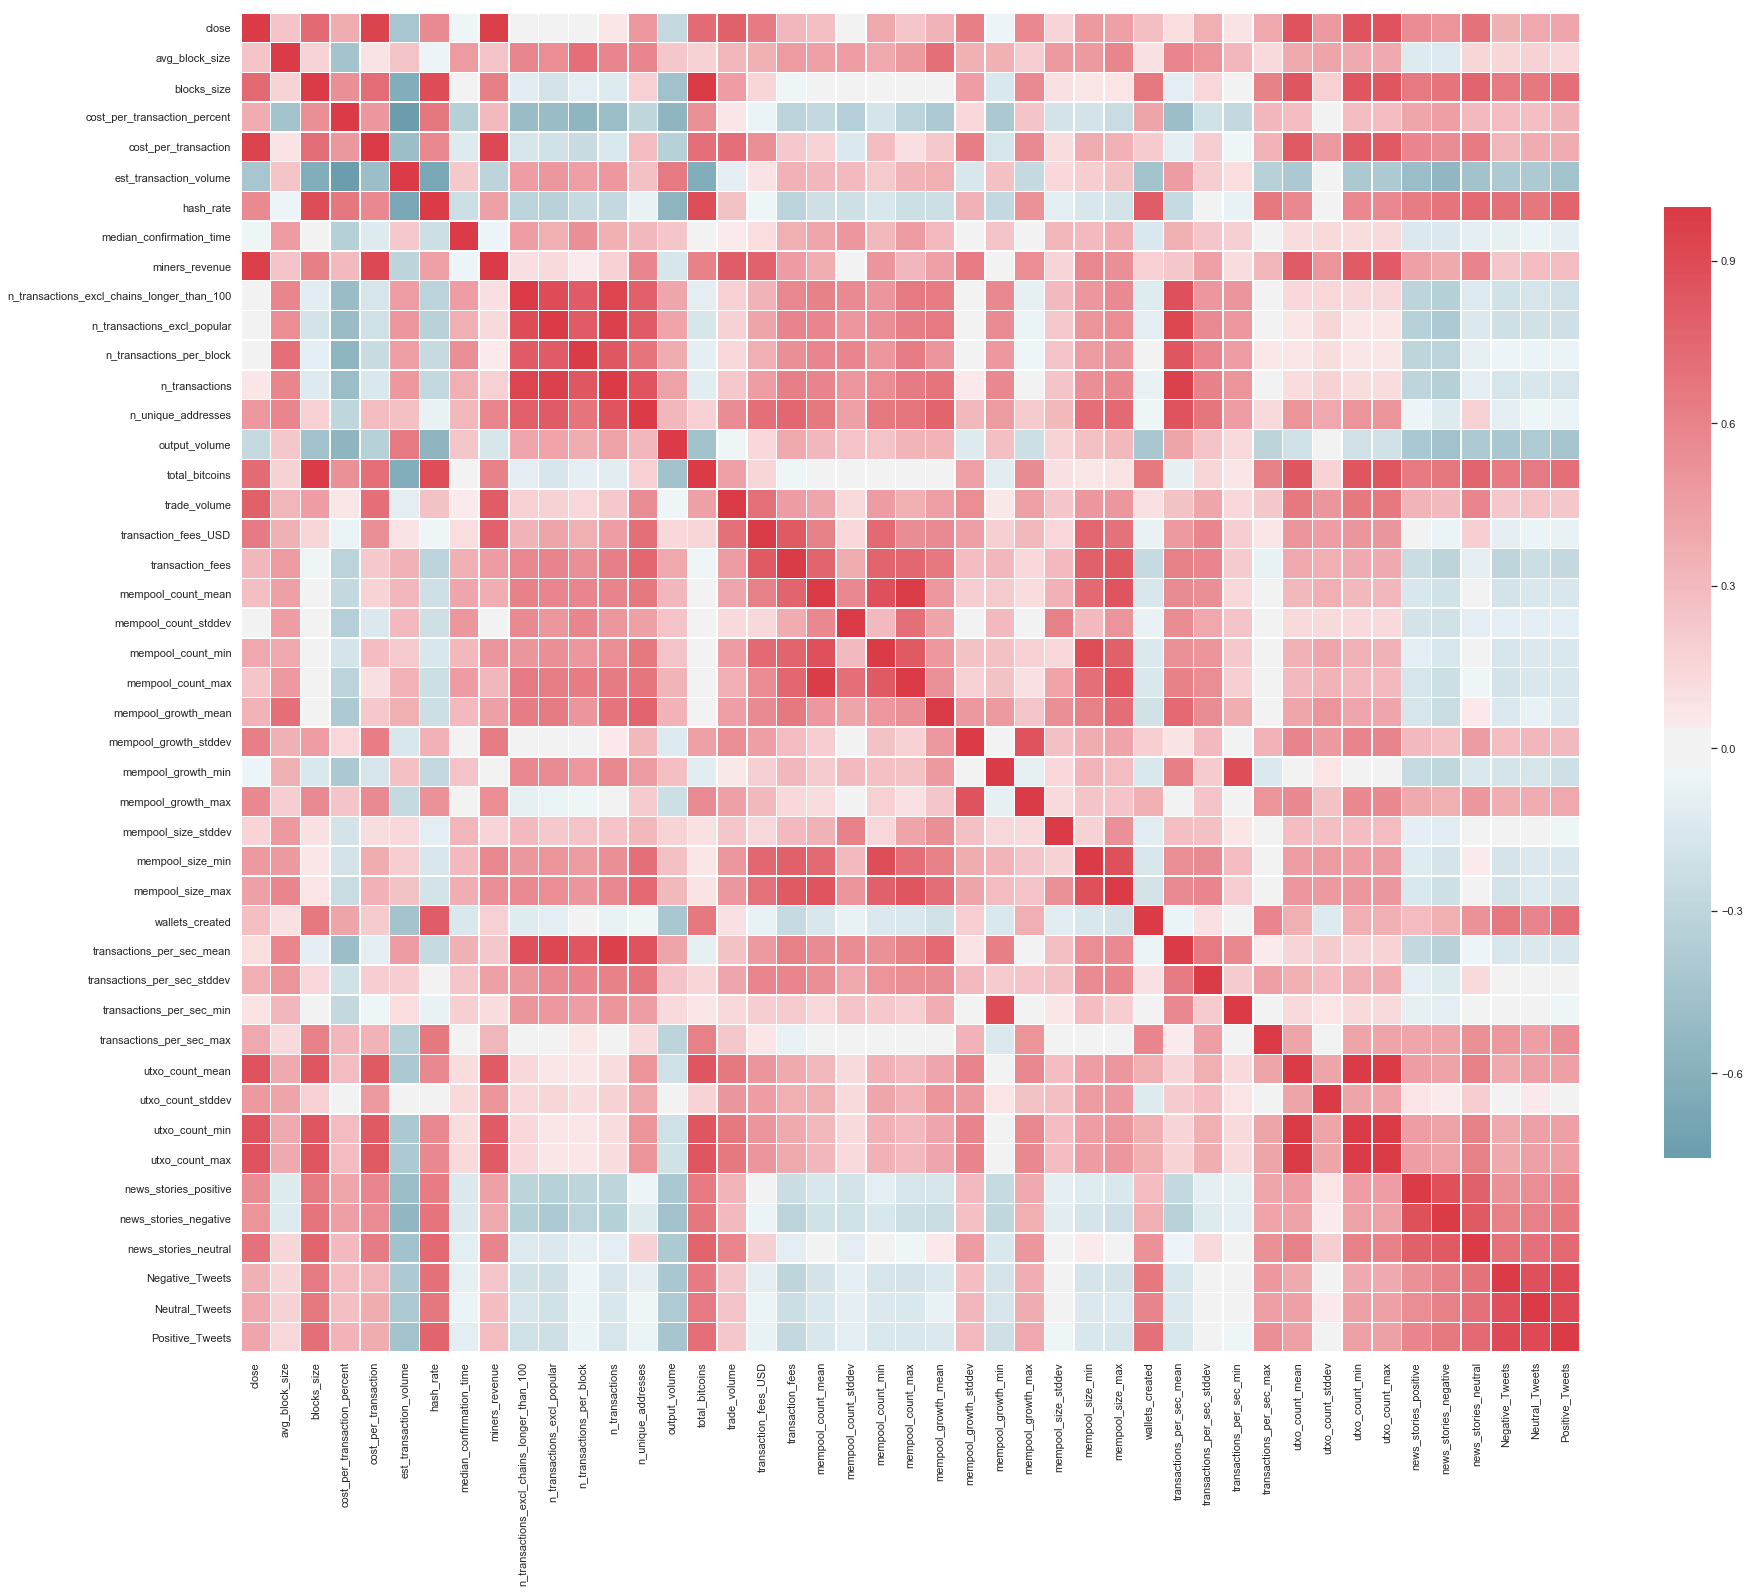

In [139]:
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(30, 25))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax =sns.heatmap(timeseries_merged.corr(), cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [188]:
timeseries_merged.drop(['n_transactions_excl_chains_longer_than_100','n_transactions_excl_popular','n_transactions_per_block'],axis=1, inplace=True)

In [189]:
timeseries_merged.drop(['mempool_count_stddev','mempool_growth_min'],axis=1, inplace=True)

In [142]:
timeseries_merged.drop(['transactions_per_sec_min','transactions_per_sec_mean'],axis=1, inplace=True)

In [143]:
timeseries_merged.drop(['mempool_size_stddev'],axis=1, inplace=True)

In [144]:
timeseries_merged.drop(['utxo_count_min','utxo_count_max'],axis=1, inplace=True)

In [145]:
timeseries_merged.drop(['mempool_count_max','n_transactions'],axis=1, inplace=True)

In [303]:
timeseries_merged.to_csv('../Data/Output/timeseries_merged.csv')

## Modeling - LSTM

In [ ]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM




In [ ]:
timeseries_merged_df = pd.read_csv('../Data/Output/timeseries_merged.csv',encoding='latin1')

In [ ]:
timeseries_merged_df.set_index('Date', inplace=True)

In [ ]:
# Keeping different scalers for X and Y
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))


In [ ]:
x_cols = list(timeseries_merged_df.columns)

In [ ]:
x_cols.remove('close')

In [ ]:
y_col=['close']

In [ ]:
#timeseries_merged[x_cols] = x_scaler.fit_transform(timeseries_merged[x_cols])
#timeseries_merged[y_col] = y_scaler.fit_transform(timeseries_merged[y_col])

In [ ]:
timeseries_merged_df['difficulty'] = timeseries_merged_df['difficulty'].apply(lambda x: '{:.2f}'.format(x))

In [ ]:
timeseries_merged_df.head()

In [ ]:
values = timeseries_merged_df.values
n_train_hours = 760
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

In [ ]:
test.shape

In [ ]:
n_features = 35 #Features in the dataset.
n_obs = 35
n_days = 1

In [ ]:
# split into input and outputs
train_X, train_y = train[:, 1:n_obs], train[:, -n_features]


In [ ]:
train_X.shape

In [ ]:
train_y.shape

In [ ]:
test_X, test_y = test[:, 1:n_obs], test[:, -n_features]

In [ ]:
test_X.shape

In [ ]:
test_y.shape

In [ ]:
#timeseries_merged[x_cols] = x_scaler.fit_transform(timeseries_merged[x_cols])
#timeseries_merged[y_col] = y_scaler.fit_transform(timeseries_merged[y_col])

In [ ]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
train_X = x_scaler.fit_transform(train_X)
train_y = y_scaler.fit_transform(train_y)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(35, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)
# plot history

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 34,))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = concatenate((yhat, test_X[:, -34:]), axis=1)
#scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
x_scaler.fit(inv_yhat)
inv_yhat = x_scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_y, test_X[:, -34:]), axis=1)
inv_y = y_scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
yhat = model.predict(test_X)

In [ ]:
test_X = test_X.reshape((test_X.shape[0], 34,))

In [ ]:
inv_yhat = concatenate((yhat, test_X[:, -34:]), axis=1)

In [ ]:
real_prediction_test = y_scaler.inverse_transform(inv_yhat)

In [ ]:
real_prediction_test

In [ ]:
inv_yhat.shape

In [ ]:
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat, label='Predicted')

## Making Predictions

## Importing Test Timeseries

In [304]:
df_test_timeseries =pd.read_csv('../Data/Bitcoin_Data2/test_timeseries2.csv',encoding='latin1')
df_test_timeseries.rename(columns = {"date":"Date"}, inplace=True)
df_test_timeseries['Date'] = df_test_timeseries.Date.apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%#m/%#d/%Y"))

In [305]:
df_test_timeseries.head()

,Date,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,n_transactions_excl_chains_longer_than_100,n_transactions_excl_popular,n_transactions_per_block,n_transactions,n_unique_addresses,output_volume,total_bitcoins,trade_volume,transaction_fees_USD,transaction_fees,mempool_count_mean,mempool_count_stddev,mempool_count_min,mempool_count_max,mempool_growth_mean,mempool_growth_stddev,mempool_growth_min,mempool_growth_max,mempool_size_mean,mempool_size_stddev,mempool_size_min,mempool_size_max,wallets_created,transactions_per_sec_mean,transactions_per_sec_stddev,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral
0,12/1/2018,1.068438,192924.029808,0.923090,26.914157,6.653303e+12,7.051436e+08,171285.334800,4.101145e+07,11.866667,6.509108e+06,147390.0,234023.0,1950.379032,241847.0,420224.0,1.246165e+06,17402600.0,4.638681e+08,128103.051425,31.117312,5007.537384,3548.299304,70.0,18582.0,1212.626852,1299.127130,317.350000,35337.583333,3.125405e+06,2.250077e+06,24268.5,8712277.5,747651977.0,2.744306,1.323969,1.066667,20.683333,5.838090e+07,12711.208037,58353357.0,58406280.0,915.0,297.0,508.0,110.0
1,12/2/2018,1.005272,193038.630789,1.715932,27.105352,6.653303e+12,3.517405e+08,84399.905117,3.770407e+07,9.883333,6.035630e+06,126792.0,215902.0,1953.271930,222673.0,364378.0,9.768300e+05,17404025.0,3.110201e+08,96876.093744,23.245353,3411.994097,2613.627485,48.0,11091.0,1086.992222,1195.008262,229.066667,35162.700000,1.792216e+06,1.523878e+06,23871.0,6754725.0,748288608.0,2.525475,1.147508,0.850000,24.466667,5.839757e+07,12797.050623,58369018.0,58411610.0,879.0,287.0,497.0,95.0
2,12/3/2018,1.101028,193164.148009,0.455677,24.006523,6.194016e+12,1.267830e+09,319552.043684,3.199801e+07,11.150000,5.777218e+06,157295.0,231011.0,2110.982456,240652.0,426799.0,1.487029e+06,17405450.0,3.845152e+08,123495.728881,31.126648,8244.337963,6258.259213,101.5,23969.0,1324.301690,1495.893197,312.550000,48435.783333,6.303715e+06,4.956393e+06,45424.0,15545919.0,749000256.0,2.956644,1.059332,1.183333,26.566667,5.843081e+07,9615.069463,58408024.0,58447369.0,1119.0,386.0,552.0,181.0
3,12/4/2018,1.083460,193313.665436,0.279035,25.753689,5.646404e+12,2.493726e+09,629491.330519,3.873443e+07,9.800000,6.958363e+06,168653.0,260203.0,1957.891304,270189.0,492964.0,2.223960e+06,17407175.0,4.311405e+08,124787.404576,31.500092,6501.516319,4812.471135,98.5,19097.5,1273.462083,1685.869382,372.650000,45882.666667,4.381025e+06,3.512565e+06,48968.0,13324239.5,749539960.0,2.964977,1.054051,1.200000,26.100000,5.845325e+07,9025.975571,58439456.0,58464237.0,1112.0,383.0,541.0,188.0
4,12/5/2018,1.036768,193448.445287,0.442812,24.839415,5.646404e+12,1.438836e+09,372914.991753,3.648895e+07,9.300000,6.371335e+06,152519.0,246517.0,1973.084615,256501.0,438437.0,1.713031e+06,17408800.0,3.604632e+08,101517.417666,26.311102,4741.071644,3568.925242,96.5,15013.0,1317.076539,1350.694414,354.616667,39338.333333,3.151525e+06,2.623690e+06,44969.0,9431061.0,750294697.0,3.026887,0.990134,1.200000,26.050000,5.849635e+07,9608.661188,58473643.0,58511025.0,1040.0,359.0,532.0,149.0


### Test Tweets

### WEIGHTED APPROACH

In [259]:
df_test_tweets =pd.read_csv('../Data/Bitcoin_Data2/test_tweets.csv',encoding='latin1')
df_test_tweets['text'] = df_test_tweets['text'].astype(str)
df_test_tweets['text'] = df_test_tweets.text.apply(lambda x:clean_tweet(x))
df_test_tweets['Polarity'] = df_test_tweets.text.apply(lambda x:polarity(x))
df_test_tweets[['Date','Time']] = df_test_tweets['created_date'].str.split(' ',expand=True)
df_test_tweets.drop(['created_date','Time'],axis=1, inplace=True)

test_tweet_polarity = df_test_tweets[['Date','Polarity','retweet_count','favorite_count','follower_count']]
test_dummy = pd.get_dummies(test_tweet_polarity['Polarity'])
test_tweet_polarity = pd.concat([test_tweet_polarity,test_dummy], axis=1)
#test_tweet_polarity = test_tweet_polarity[test_tweet_polarity.favorite_count != '@BitcoinByte']
test_tweet_polarity.fillna(0, inplace=True)
test_tweet_polarity['favorite_count'] = test_tweet_polarity['favorite_count'].astype(int)
test_tweet_polarity['negative'] = test_tweet_polarity['negative'].astype(int)
test_tweet_polarity['neutral'] = test_tweet_polarity['neutral'].astype(int)
test_tweet_polarity['positive'] = test_tweet_polarity['positive'].astype(int)
test_tweet_polarity['retweet_count'] = (test_tweet_polarity['retweet_count'] - test_tweet_polarity['retweet_count'].min())/(test_tweet_polarity['retweet_count'].max() - test_tweet_polarity['retweet_count'].min())
test_tweet_polarity['follower_count'] = (test_tweet_polarity['follower_count'] - test_tweet_polarity['follower_count'].min())/(test_tweet_polarity['follower_count'].max() - test_tweet_polarity['follower_count'].min())
test_tweet_polarity['favorite_count'] = (test_tweet_polarity['favorite_count'] - test_tweet_polarity['favorite_count'].min())/(test_tweet_polarity['favorite_count'].max() - test_tweet_polarity['favorite_count'].min())
test_tweet_polarity['weight'] = test_tweet_polarity['retweet_count']+test_tweet_polarity['favorite_count']+test_tweet_polarity['follower_count']

for idx, row in test_tweet_polarity.iterrows():
    if  test_tweet_polarity.loc[idx,'negative'] == 1 :
        test_tweet_polarity.loc[idx,'negative'] = test_tweet_polarity.loc[idx,'negative'] + test_tweet_polarity.loc[idx,'weight']
    elif test_tweet_polarity.loc[idx,'neutral'] == 1 :
        test_tweet_polarity.loc[idx,'neutral'] = test_tweet_polarity.loc[idx,'neutral'] + test_tweet_polarity.loc[idx,'weight']
    elif test_tweet_polarity.loc[idx,'positive'] == 1 :
        test_tweet_polarity.loc[idx,'positive'] = test_tweet_polarity.loc[idx,'positive'] + test_tweet_polarity.loc[idx,'weight']


test_tweet_polarity = test_tweet_polarity.groupby(['Date'])['negative','neutral','positive'].sum().reset_index()
test_tweet_polarity.to_csv('../Data/Output/test_tweet_polarity.csv')

## SCALER approach

In [306]:
df_test_tweets =pd.read_csv('../Data/Bitcoin_Data2/test_tweets.csv',encoding='latin1')
df_test_tweets['text'] = df_test_tweets['text'].astype(str)
df_test_tweets['text'] = df_test_tweets.text.apply(lambda x:clean_tweet(x))
df_test_tweets['Polarity'] = df_test_tweets.text.apply(lambda x:polarity(x))
df_test_tweets[['Date','Time']] = df_test_tweets['created_date'].str.split(' ',expand=True)
df_test_tweets.drop(['created_date','Time'],axis=1, inplace=True)

test_tweet_polarity = df_test_tweets[['Date','Polarity','retweet_count','favorite_count','follower_count']]
test_dummy = pd.get_dummies(test_tweet_polarity['Polarity'])
test_tweet_polarity = pd.concat([test_tweet_polarity,test_dummy], axis=1)
#test_tweet_polarity = test_tweet_polarity[test_tweet_polarity.favorite_count != '@BitcoinByte']
test_tweet_polarity.fillna(0, inplace=True)
test_tweet_polarity['favorite_count'] = test_tweet_polarity['favorite_count'].astype(int)
test_tweet_polarity['negative'] = test_tweet_polarity['negative'].astype(int)
test_tweet_polarity['neutral'] = test_tweet_polarity['neutral'].astype(int)
test_tweet_polarity['positive'] = test_tweet_polarity['positive'].astype(int)


test_count_scaler = MinMaxScaler(feature_range=(0, 2))
test_fav_scaler = MinMaxScaler(feature_range=(0, 1))
test_follower_scaler = MinMaxScaler(feature_range=(0, 3))

test_tweet_polarity[['retweet_count']] = test_count_scaler.fit_transform(test_tweet_polarity[['retweet_count']])
test_tweet_polarity[['favorite_count']] = test_fav_scaler.fit_transform(test_tweet_polarity[['favorite_count']])
test_tweet_polarity[['follower_count']] = test_follower_scaler.fit_transform(test_tweet_polarity[['follower_count']])

test_tweet_polarity['weight'] = test_tweet_polarity['retweet_count']+test_tweet_polarity['favorite_count']+test_tweet_polarity['follower_count']

for idx, row in test_tweet_polarity.iterrows():
    if  test_tweet_polarity.loc[idx,'negative'] == 1 :
        test_tweet_polarity.loc[idx,'negative'] = test_tweet_polarity.loc[idx,'negative'] + test_tweet_polarity.loc[idx,'weight']
    elif test_tweet_polarity.loc[idx,'neutral'] == 1 :
        test_tweet_polarity.loc[idx,'neutral'] = test_tweet_polarity.loc[idx,'neutral'] + test_tweet_polarity.loc[idx,'weight']
    elif test_tweet_polarity.loc[idx,'positive'] == 1 :
        test_tweet_polarity.loc[idx,'positive'] = test_tweet_polarity.loc[idx,'positive'] + test_tweet_polarity.loc[idx,'weight']


test_tweet_polarity = test_tweet_polarity.groupby(['Date'])['negative','neutral','positive'].sum().reset_index()
test_tweet_polarity.to_csv('../Data/Output/test_tweet_polarity.csv')

## Non weighted

In [ ]:
df_test_tweets =pd.read_csv('../Data/Bitcoin_Data2/test_tweets.csv',encoding='latin1')
df_test_tweets['text'] = df_test_tweets['text'].astype(str)
df_test_tweets['text'] = df_test_tweets.text.apply(lambda x:clean_tweet(x))
df_test_tweets['Polarity'] = df_test_tweets.text.apply(lambda x:polarity(x))
df_test_tweets[['Date','Time']] = df_test_tweets['created_date'].str.split(' ',expand=True)
df_test_tweets.drop(['created_date','Time'],axis=1, inplace=True)
test_tweet_polarity = df_test_tweets[['Date','Polarity']]
test_dummy = pd.get_dummies(test_tweet_polarity['Polarity'])
test_tweet_polarity = pd.concat([test_tweet_polarity,test_dummy], axis=1)
test_tweet_polarity.drop(['Polarity'],axis=1, inplace=True)
test_tweet_polarity = test_tweet_polarity.groupby(['Date'])['negative','neutral','positive'].sum().reset_index()
test_tweet_polarity.to_csv('../Data/Output/test_tweet_polarity.csv')

In [307]:
test_tweet_polarity.head()

,Date,negative,neutral,positive
0,2018-12-01,50.952893,113.726201,130.891052
1,2018-12-02,47.164804,150.869418,192.540884
2,2018-12-03,50.645421,221.967934,179.629582
3,2018-12-04,55.127732,148.565647,178.383022
4,2018-12-05,81.644125,166.521024,189.118929


### Merge Test Tweet and Timeseries

In [261]:
df_test_timeseries.shape

(113, 46)

In [262]:
test_tweet_polarity.shape

(113, 4)

In [308]:
##CONVERTING DATE FORMAT
test_tweet_polarity['Date'] = test_tweet_polarity.Date.apply(lambda x:datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%#m/%#d/%Y"))

In [309]:
test_timeseries_merged = pd.merge(df_test_timeseries, test_tweet_polarity, on='Date', how='inner')

In [265]:
test_timeseries_merged.shape

(113, 49)

In [266]:
test_timeseries_merged.head()

,Date,avg_block_size,blocks_size,cost_per_transaction_percent,cost_per_transaction,difficulty,est_transaction_volume_USD,est_transaction_volume,hash_rate,median_confirmation_time,miners_revenue,n_transactions_excl_chains_longer_than_100,n_transactions_excl_popular,n_transactions_per_block,n_transactions,n_unique_addresses,output_volume,total_bitcoins,trade_volume,transaction_fees_USD,transaction_fees,mempool_count_mean,mempool_count_stddev,mempool_count_min,mempool_count_max,mempool_growth_mean,mempool_growth_stddev,mempool_growth_min,mempool_growth_max,mempool_size_mean,mempool_size_stddev,mempool_size_min,mempool_size_max,wallets_created,transactions_per_sec_mean,transactions_per_sec_stddev,transactions_per_sec_min,transactions_per_sec_max,utxo_count_mean,utxo_count_stddev,utxo_count_min,utxo_count_max,news_stories_total,news_stories_positive,news_stories_negative,news_stories_neutral,negative,neutral,positive
0,12/1/2018,1.068438,192924.029808,0.923090,26.914157,6.653303e+12,7.051436e+08,171285.334800,4.101145e+07,11.866667,6.509108e+06,147390.0,234023.0,1950.379032,241847.0,420224.0,1.246165e+06,17402600.0,4.638681e+08,128103.051425,31.117312,5007.537384,3548.299304,70.0,18582.0,1212.626852,1299.127130,317.350000,35337.583333,3.125405e+06,2.250077e+06,24268.5,8712277.5,747651977.0,2.744306,1.323969,1.066667,20.683333,5.838090e+07,12711.208037,58353357.0,58406280.0,915.0,297.0,508.0,110.0,37.676332,80.636648,93.948681
1,12/2/2018,1.005272,193038.630789,1.715932,27.105352,6.653303e+12,3.517405e+08,84399.905117,3.770407e+07,9.883333,6.035630e+06,126792.0,215902.0,1953.271930,222673.0,364378.0,9.768300e+05,17404025.0,3.110201e+08,96876.093744,23.245353,3411.994097,2613.627485,48.0,11091.0,1086.992222,1195.008262,229.066667,35162.700000,1.792216e+06,1.523878e+06,23871.0,6754725.0,748288608.0,2.525475,1.147508,0.850000,24.466667,5.839757e+07,12797.050623,58369018.0,58411610.0,879.0,287.0,497.0,95.0,33.832619,113.716915,128.967312
2,12/3/2018,1.101028,193164.148009,0.455677,24.006523,6.194016e+12,1.267830e+09,319552.043684,3.199801e+07,11.150000,5.777218e+06,157295.0,231011.0,2110.982456,240652.0,426799.0,1.487029e+06,17405450.0,3.845152e+08,123495.728881,31.126648,8244.337963,6258.259213,101.5,23969.0,1324.301690,1495.893197,312.550000,48435.783333,6.303715e+06,4.956393e+06,45424.0,15545919.0,749000256.0,2.956644,1.059332,1.183333,26.566667,5.843081e+07,9615.069463,58408024.0,58447369.0,1119.0,386.0,552.0,181.0,34.938430,155.527135,124.085115
3,12/4/2018,1.083460,193313.665436,0.279035,25.753689,5.646404e+12,2.493726e+09,629491.330519,3.873443e+07,9.800000,6.958363e+06,168653.0,260203.0,1957.891304,270189.0,492964.0,2.223960e+06,17407175.0,4.311405e+08,124787.404576,31.500092,6501.516319,4812.471135,98.5,19097.5,1273.462083,1685.869382,372.650000,45882.666667,4.381025e+06,3.512565e+06,48968.0,13324239.5,749539960.0,2.964977,1.054051,1.200000,26.100000,5.845325e+07,9025.975571,58439456.0,58464237.0,1112.0,383.0,541.0,188.0,37.824774,103.030133,128.325976
4,12/5/2018,1.036768,193448.445287,0.442812,24.839415,5.646404e+12,1.438836e+09,372914.991753,3.648895e+07,9.300000,6.371335e+06,152519.0,246517.0,1973.084615,256501.0,438437.0,1.713031e+06,17408800.0,3.604632e+08,101517.417666,26.311102,4741.071644,3568.925242,96.5,15013.0,1317.076539,1350.694414,354.616667,39338.333333,3.151525e+06,2.623690e+06,44969.0,9431061.0,750294697.0,3.026887,0.990134,1.200000,26.050000,5.849635e+07,9608.661188,58473643.0,58511025.0,1040.0,359.0,532.0,149.0,60.583100,125.615671,141.835649


In [158]:
test_timeseries_merged.drop(['n_transactions_excl_chains_longer_than_100','n_transactions_excl_popular','n_transactions_per_block','mempool_count_stddev','mempool_growth_min','median_confirmation_time','transactions_per_sec_min','transactions_per_sec_mean','mempool_size_stddev','utxo_count_min','utxo_count_max','mempool_count_max','n_transactions'],axis=1, inplace=True)

In [310]:
test_timeseries_merged.rename(columns = {"positive":"Positive_Tweets","negative":"Negative_Tweets","neutral":"Neutral_Tweets"}, inplace=True)
test_timeseries_merged.set_index('Date', inplace=True)

In [311]:
test_timeseries_merged['difficulty'] = test_timeseries_merged['difficulty'].apply(lambda x: '{:.2f}'.format(x))
test_timeseries_merged['hash_rate'] = test_timeseries_merged['hash_rate'].apply(lambda x: '{:.2f}'.format(x))
test_timeseries_merged['miners_revenue'] = test_timeseries_merged['miners_revenue'].apply(lambda x: '{:.2f}'.format(x))
test_timeseries_merged['output_volume'] = test_timeseries_merged['output_volume'].apply(lambda x: '{:.2f}'.format(x))
test_timeseries_merged['trade_volume'] = test_timeseries_merged['trade_volume'].apply(lambda x: '{:.2f}'.format(x))
test_timeseries_merged['utxo_count_mean'] = test_timeseries_merged['utxo_count_mean'].apply(lambda x: '{:.2f}'.format(x))

In [312]:
test_timeseries_merged['est_transaction_volume_USD'] = test_timeseries_merged['est_transaction_volume_USD'].apply(lambda x: '{:.2f}'.format(x))

In [313]:
test_timeseries_merged['mempool_size_mean'] = test_timeseries_merged['mempool_size_mean'].apply(lambda x: '{:.2f}'.format(x))

In [163]:
test_timeseries_merged.drop(['news_stories_total'],axis=1, inplace=True)

In [314]:
test_timeseries_merged.to_csv('../Data/Output/test_timeseries_merged.csv')

## Test Prediction

In [ ]:
test_predict = pd.read_csv('../Data/Output/test_timeseries_merged.csv',encoding='latin1')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))


In [ ]:
test_predict.set_index('Date', inplace=True)

In [ ]:
test_predict[test_predict.columns] = scaler.fit_transform(test_predict[test_predict.columns])

In [ ]:
values = test_predict.values
#n_train_hours = 0
#train = values[:n_train_hours, :]
test = values[:, :]
test.shape

In [ ]:
n_features = 34 #Features in the dataset.
n_obs = 34
n_days = 1

In [ ]:
# split into input and outputs
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
test_y.shape

In [ ]:
test_X 

In [ ]:
yhat = model.predict(test_X)

In [ ]:
test_X = test_X.reshape((test_X.shape[0], n_days* n_features,))

In [ ]:
test_X.shape

In [ ]:
invert_yhat = concatenate((yhat, test_X[:, -34:]), axis=1)

In [ ]:
invert_yhat

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(invert_yhat)

In [ ]:
predicted_val = scaler.inverse_transform(invert_yhat)

In [ ]:
predicted_val

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days* n_features,))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -34:]), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -34:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat, label='Predicted')

In [ ]:
inv_yhat = concatenate((yhat, test_X[:, -34:]), axis=1)
#scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inversed = scaler.inverse_transform(inv_yhat)

In [ ]:
inversed